In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import networkx as nx
import tweepy
import pickle
import urllib.request
import io
from PIL import Image
import plotly
import plotly.offline as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [2]:
with open('data/graph.bin', 'rb') as fp:
    graph = pickle.loads(fp.read())

with open('data/visited.bin', 'rb') as fp:
    visited = pickle.loads(fp.read())

print('#{nodes}: %d' % graph.number_of_nodes())
print('#{edges}: %d' % graph.number_of_edges())
print('visited: %d' % len(visited))

#{nodes}: 6004
#{edges}: 9468
visited: 15


In [3]:
ranks = nx.pagerank(graph)
ranked = list(sorted(ranks, key=ranks.get, reverse=True))
graph.remove_nodes_from(ranked[12:])
len(graph.nodes())

12

In [4]:
import config
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token_key, config.access_token_secret)
api = tweepy.API(auth)

In [5]:
# get screen_name and image
for user_id in graph.nodes():
    status = api.get_user(user_id)
    graph.node[user_id]['screen_name'] = status.screen_name
    file = io.BytesIO(urllib.request.urlopen(status.profile_image_url).read())
    graph.node[user_id]['image']= Image.open(file)
    graph.node[user_id]['image_url'] = status.profile_image_url

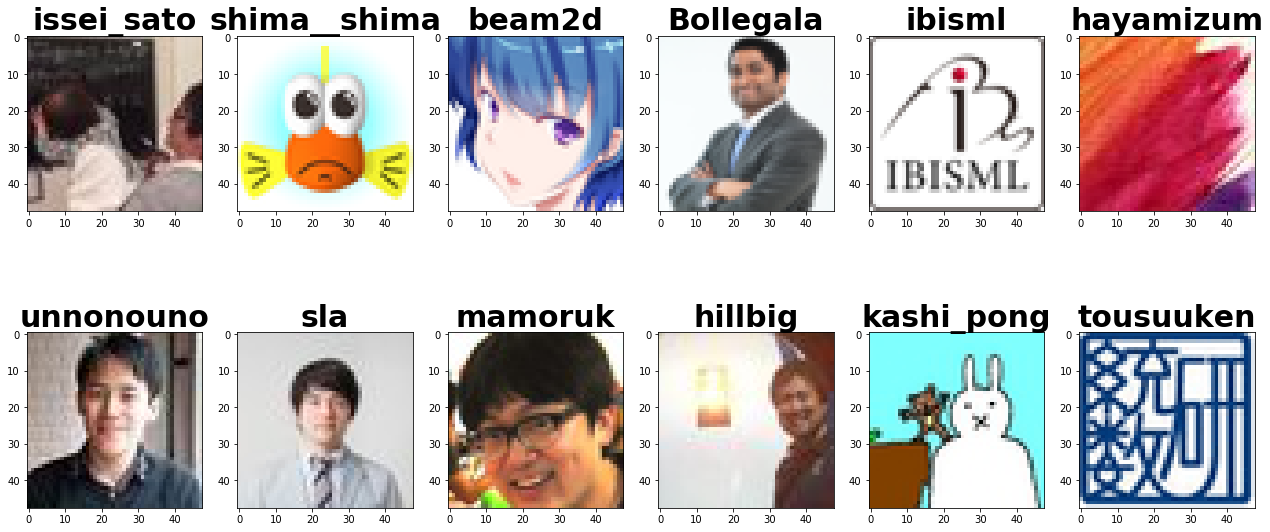

In [6]:
plt.subplots(2, 6, figsize=(22, 10))

cnt = 1
for user_id in graph.nodes():
    plt.subplot(2, 6, cnt)
    plt.title(s=graph.node[user_id]['screen_name'], fontsize=30, fontweight='bold')
    plt.imshow(graph.node[user_id]['image'])
    cnt += 1

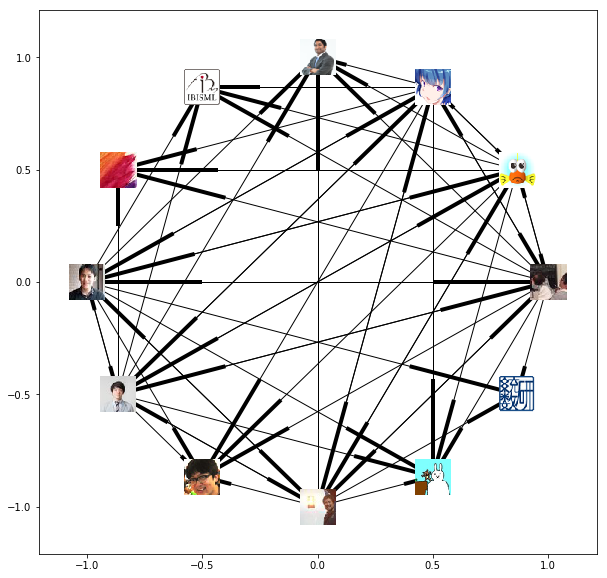

In [7]:
# pos = nx.spring_layout(graph)
pos = nx.circular_layout(graph)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
nx.draw_networkx_edges(graph, pos, ax=ax, arrows=True, zorder=10)

trans_data = ax.transData.transform
trans_figure_inv = fig.transFigure.inverted().transform

size = 0.05
for user_id in graph.nodes():
    x, y = trans_figure_inv(trans_data(pos[user_id]))
    rect = [x - size/2, y - size/2, size, size]
    ax_image = plt.axes(rect)
    ax_image.imshow(graph.node[user_id]['image'], zorder=1)
    ax_image.axis('off')

In [8]:
# pos = nx.spring_layout(graph)
pos = nx.circular_layout(graph)

Xv = [v[0] for v in pos.values()]
Yv = [v[1] for v in pos.values()]
Xed = np.array([[pos[edge[0]][0], pos[edge[1]][0]] for edge in graph.edges()]).flatten()
Yed = np.array([[pos[edge[0]][1], pos[edge[1]][1]] for edge in graph.edges()]).flatten()
labels = graph.nodes()

trace1=go.Scatter(x=Xed,
                  y=Yed,
                  mode='lines',
                  line=go.Line(width=0.5,color='#888'),
                  name='follow',
                  hoverinfo='none'
)
trace2=go.Scatter(x=Xv,
                  y=Yv,
                  mode='markers',
                  name='users',
                  marker=go.Marker(symbol='dot', color='red', size=20),
                  text=labels,
                  hoverinfo='text'
)

images = [{"source": graph.node[user_id]['image_url'], 
           "x": pos[user_id][0]/2.3 + 0.48, # hardcoding transformation
           "y": pos[user_id][1]/2.3 + 0.55, # not good
           "sizex": 0.1, 
           "sizey": 0.1,
           } for user_id in graph.nodes()]
        
layout= go.Layout(images=images)
fig=go.Figure(data=[trace1, trace2], layout=layout)
py.iplot(fig)